### Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)})

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Google Drive mounten
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [3]:
data = pd.read_csv('/content/drive/My Drive/datasets/Energieverbrauch.csv')
data.head()

,Date,Consumption
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel.
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen:
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren.
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt.
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [5]:
data['Weekday'] = data.index.weekday
data['Year'] = data.index.year
data['Month'] = data.index.month

## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren.
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [6]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]

# Für jeden Wochentag (x) wird geprüft, ob er kleiner als 5 ist.
# ja - Weekday (0 steht in der Spalte "Weekend")
# nein - Weekend (1 steht in der Spalte "Weekend")

## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern.
- Versuchen Sie zu verstehen, was passiert. Was macht die Hilfsfunktion?




 **Was macht die Hilfsfunktion?**
- Die Funktion nimmt einen DataFrame als Eingabe und teilt ihn in Trainings-, Validierungs- und Testmenge auf mit ``np.split()``
- ``df.sample()`` - wird zufällige Zeilen des gesamten Datenrahmens (``frac=1``) erzeugt
- Labels für die 3 Sets aus der Spalte 'Consumption' des ursprünglichen DataFrames ausgewählt
- die Spalten 'Consumption' und 'Year' werden entfernt, da 'Consumption' die Labels sind


In [7]:
# Hilfsfunktion
def generate_sets(df):

    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

    # Auswahl der Label durch Auswahl der entsprechenden Spalten
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']

    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)

    return X_train, y_train, X_validate, y_validate, X_test, y_test


## Aufgabe 6
- Oben in der Hilfsfunktion wird das Merkmal 'Year' aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?
- Weiterhin wird aus X_train/validate/test die Spalte "Consumption" gelöscht. Wieso macht das Sinn?
- Wozu braucht man Trainings-, Validierungs- und Testmenge?

Antwort: <br>
**1. Warum wird das Merkmal 'Year' aus den Datensätzen entfernt?**<br>
das Merkmal Jahr ist irrelevant im Bezug auf den Strombedarf<br><br>
**2. Warum wird die Spalte "Consumption" aus X_train/validate/test  gelöscht**<br>
der Wert wird schon in y_train/validate/test gespeichert<br><br>
**3. Wozu braucht man Trainings-, Validierungs- und Testmenge?**<br>
für die jeweiligen Phasen<br>


**Training:**<br>
Die Trainingsmenge wird verwendet, um das Modell zu trainieren. Das bedeutet, dass das Modell auf dieser Menge von Daten "lernt", wie es die Eingabeinformationen in sinnvolle Ausgaben umwandeln kann. <br><br>
**Validierung:**<br>
Nach jedem Trainingsschritt wird das Modell auf der Validierungsgruppe getestet, um sicherzustellen, dass es nicht übermäßig an die Trainingsdaten angepasst ist (Überanpassung oder Overfitting). Die Validierungsdaten dienen dazu, die Hyperparameter des Modells zu optimieren. <br><br>
**Test:**<br>
Die Testmenge wird verwendet, um die Endleistung des Modells zu bewerten. Das Modell hat diese Daten während des Trainings nicht gesehen und wurde auch nicht auf der Validierungsgruppe optimiert. Daher gibt die Testmenge einen objektiven Einblick in die Fähigkeit des Modells, auf bisher ungesehene Daten zu generalisieren. <br><br>

In [8]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [9]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.

    Inputs:
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische
                   Darstellung des Entscheidungsbaumes)

    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann
    '''

    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)

    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_splkit und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)

    # Optionale Ausgabe generieren
    if output:

        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)

        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)

    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren.
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen.
- Diese enthält die Parameter min_samples_split und min_samples_leaf
- Was bedeuten diese Parameter? Versuchen Sie dies mithilfe der Dokumentation zu klären:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Was passiert wenn Sie diese Parameter verändern?
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. min_samples_split zwischen 2 und 2000. Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum

Antwort: <br>
**Was bedeutet die Parameter min_samples_split und min_samples_leaf?** <br>
1. ``min_samples_split`` - Die Mindestanzahl an Samples die benötigt wird, um einen internen Knoten zu teilen
2. ``min_samples_leaf`` - Die Mindestanzahl an Samples die benötigt wird, für einen Blattknoten. Jeder Nachfolger eines Split Knoten muss mindestens diese Anzahl an Samples haben.
3. Bei Änderungen von ``min_samples_split``:
- erhöhen - größer Knoten wird erzeugt und weniger feine Aufteilungen
- verringern - mehr Knoten werden erzeugt, da jetzt weniger Samples erforderlich sind, um einen inneren Knoten zu erzeugen.
4. Bei Änderungen von``min_samples_leaf``:
- erhöhen - der Baum wird genereller
- verringern - kann zu einem tieferen und verzweigteren Baum führen

|--- Weekday <= 4.50
|   |--- Month <= 2.50
|   |   |--- value: [1525.56]
|   |--- Month >  2.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1427.51]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- value: [1357.54]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1451.09]
|--- Weekday >  4.50
|   |--- value: [1162.57]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


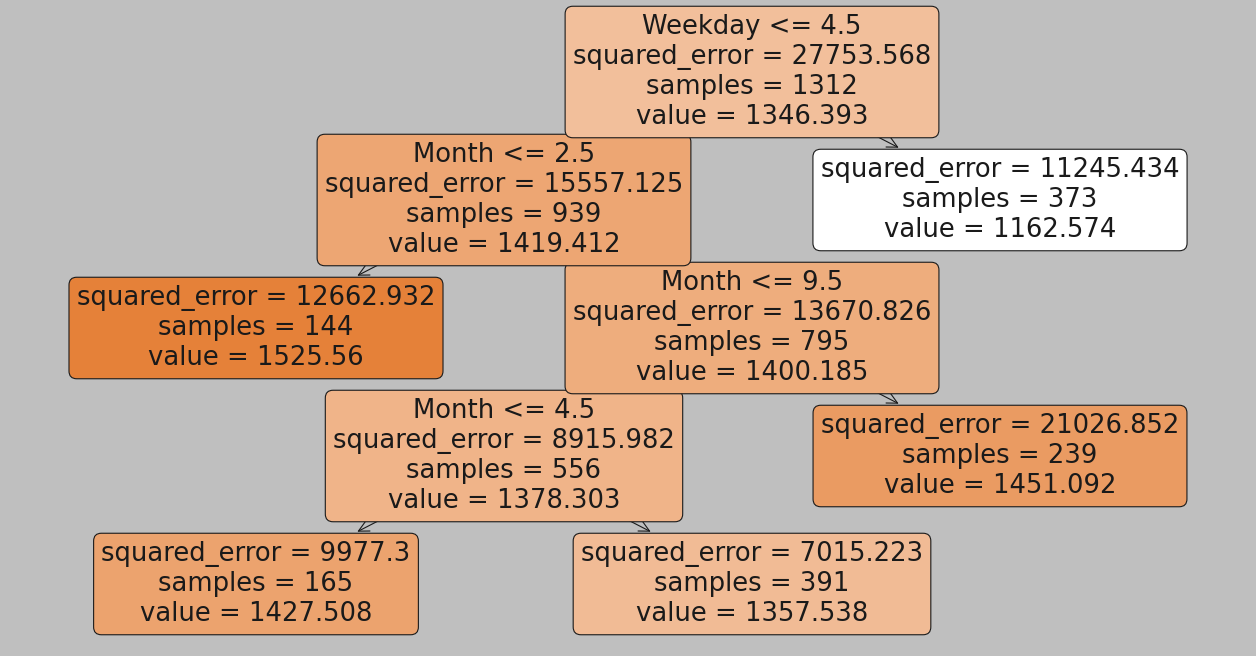

In [21]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit Hilfsfunktion generate_sets
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = 500, min_samples_leaf = 3, output=True)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [11]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.

    Inputs:
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann

    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''

    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)

    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)

    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)

    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)

    # Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)

    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }

    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE%', mae_rel*100)
        print('MAPE%', mape*100)
        print('RMSE%', rmse*100)

    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von Hilfsfunktion 3 mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort: <br>
**MAE (Mittlerer Absoluter Fehler)** - Durchschnitt der absoluten Differenz zwischen prognostizierten Werten und wahren Werten. Eine MAE von 0 bedeutet, dass kein Fehler in den prognostizierten Werten vorliegt. Ein Wert von ca. 103 ist also nicht gut. Allerdings gibt der MAE keine Auskunft darüber, ob die Fehler groß oder klein sind.<br>
<br>
**MAE%** - Normierung von MAE um auf % zu kommen. Dazu wird der MAE geteilt durch den Mittelwert der erwarteten Werte. Also konkret sind 7% der Werte nicht richtig.<br>
<br>
**MSE (Mittlerer Quadratischer Fehler)** - Der erwartete quadratische Abstand des Schätzwerts. Definiert die Qualität des Prognosemodells. Beinhaltet die Varianz als auch die Verzerrung. Je näher der Wert an 0 liegt, desto besser ist das Modell. Nicht empfohlen bei geringen Datenmengen. Der vorliegende Wert von ca. 17916.5132 ist also nicht gut.<br>
<br>
**RMSE% (Wurzel der mittleren Fehlerquadratsumme)** - Gibt an wie stark eine Prognose im durchschnitt von den tatsächlichen Beobachtungswerten abwiecht. Wird berechnet auf der Quadratwurzel des durchschnittlichen Prognosefehlers. Je größer der RMSE, desto schlechter ist dieser. Mit einem Wert von 9% ist dieser nicht gut.<br>
<br>
**MAPE% (Mittlerer absoluter prozentualer Fehler)** - prozentualer Mittelwert der absoluten Differenz zwischen prognostizierten Werten und wahren Werten, geteilt durch den wahren Wert. Auch hier ist ein niedriger Wert besser. Mit ca. 7% ist der Wert nicht gut.<br>

``Das Prognosemodell ist nicht gut, da die Abweichungen zu groß sind.``

In [12]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1346.8
MAE 78.1641
MSE 11129.661
MAE% 5.803693818884207
MAPE% 6.103966649784897
RMSE% 7.833177068314725


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

<br><br>
Diese Funktion akzeptiert Trainings- und Validierungsdaten, trainiert Entscheidungsbäume mit verschiedenen Werten für den Hyperparameter ``min_samples_split`` und evaluiert die Leistung auf der Validierungsdatenmenge. Die Ergebnisse werden in einer Liste gespeichert, grafisch dargestellt, und der optimale Wert für ``min_samples_split`` wird zurückgegeben.

**Hyperparameter** sind externe Konfigurationen eines Modells, die vor dem eigentlichen Trainingsprozess festgelegt werden und nicht durch das Modell selbst während des Trainings gelernt werden

In [13]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
    Hilfsfunktion zur Optimierung der Hyperparameter

    Inputs:
    x_train: x-Werte des Trainingsdatensatzes
    y_train: y-Werte des Trainignsdatensatzes
    x_val: x-Werte des Validierungsdatensatzes
    y_val: y-Werte des Validierungsdatensatzes
    metric: Den erwarteten Metric Typ

    Outputs:
    metrics-list:
    best_metric: Rückgabe des Optimalen Werts für die Metric
    best_min_split: Rückgabe des optimalen Min_Samples_Split Parameter-Wertes

    '''

    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]

    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []

    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000

    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):

        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False)

        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict))

        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split

    ## Plotten der Ergebnisse
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--',
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()

    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
- Wie interpretieren Sie den erzeugten Plot? Wie sollten Sie den Hyperparameter min_samples_split setzen?


**Wie interpretieren Sie den erzeugten Plot?**<br>

Je größer der Wert von min_samples_split ist, desto mehr Fehler in den prognostizierten Werten vorliegen. Das ist auf den steigenden Wert von Mean Absolute Error zurückzuführen.
<br><br>
**Wie sollten Sie den Hyperparameter min_samples_split setzen?**

Es wird von der Methode optimize_hyperparam() der optimalste Wert für min_samples_split (in dem Fall 83) als drittes Ergebnis zurückgegeben und auf das Linienplot gezeigt.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featu

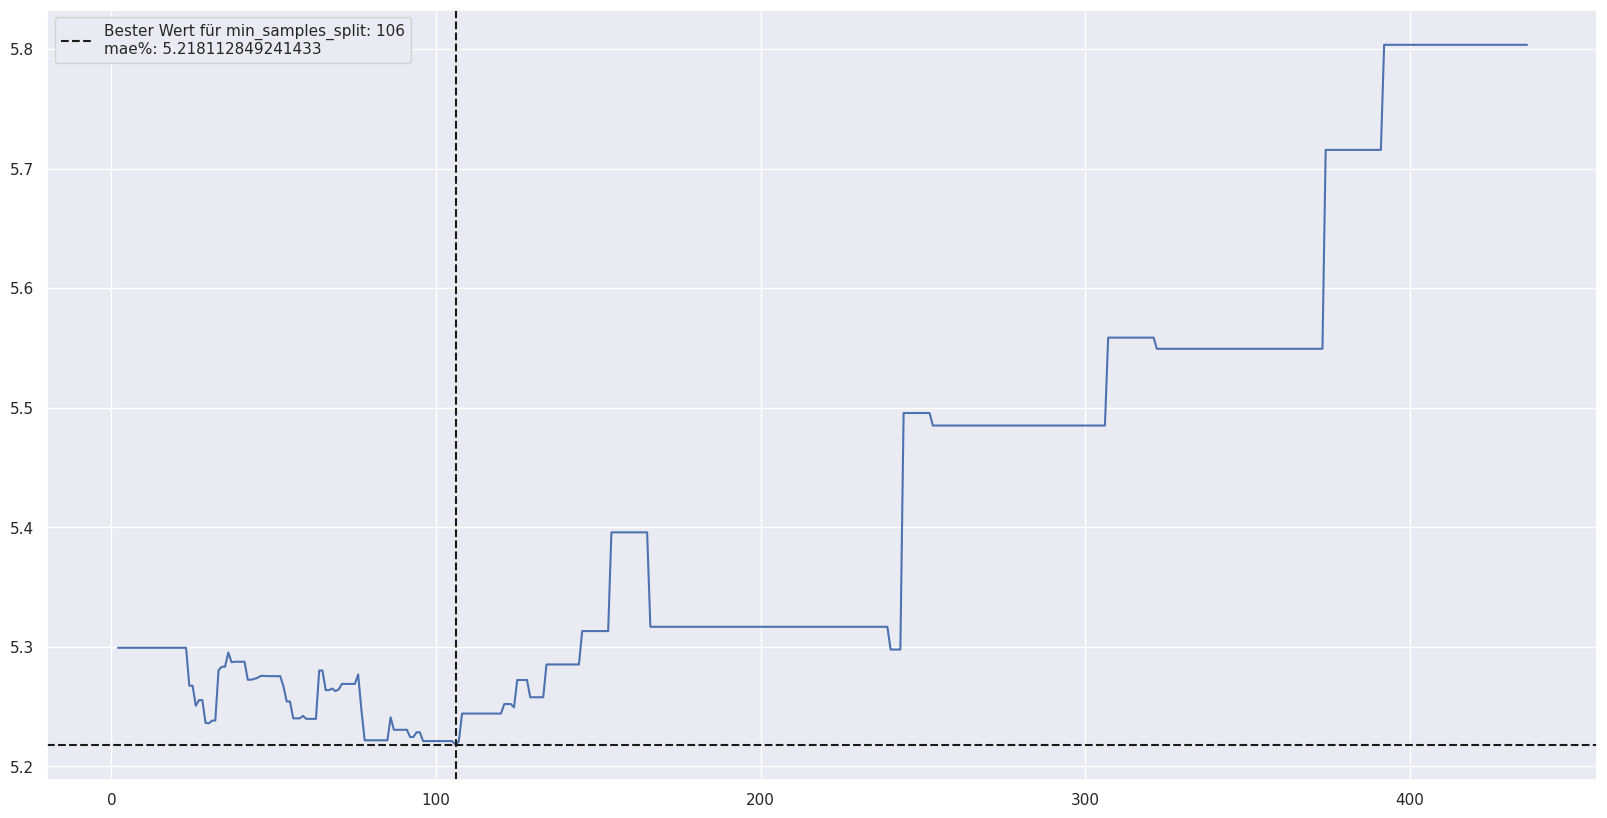

In [14]:
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val) # in die Klammer muss noch etwas rein, was?

## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.
- Was sagen Sie zu dem Ergebnis?
- Wenn Sie mit einem Fehler %mae <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?

**Was sagen Sie zu dem Ergebnis?**

Der ``MAE`` ist deutlich besser geworden. Allerdings ist der Baum zu groß und sehr schwer lesbar und sehr unübersichtlich.

**Wenn Sie mit einem Fehler % MAE <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?**

Mit min_samples_split = 450 ist der Baum noch aussagekräftig aber gleichzeitig gut nachvollziehbar.

|--- Weekday <= 4.50
|   |--- Month <= 2.50
|   |   |--- Month <= 1.50
|   |   |   |--- value: [1511.12]
|   |   |--- Month >  1.50
|   |   |   |--- value: [1538.84]
|   |--- Month >  2.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |--- value: [1369.35]
|   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |   |--- value: [1451.81]
|   |   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |   |--- value: [1402.86]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- Month <= 8.50
|   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |--- value: [1328.03]
|   |   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |   |--- Weekday <= 2.50
|   |   |   |   |   |   |   |--- Month <= 7.50
|   |   |   |   |   |   |   |   |--- value: [1381.77]
|   |   |   |   |   |   |   |--- Month >  7.50
|   |   |   |   |   |   |   |   |--- value: [1349.43]
|   |   |   |   |   | 

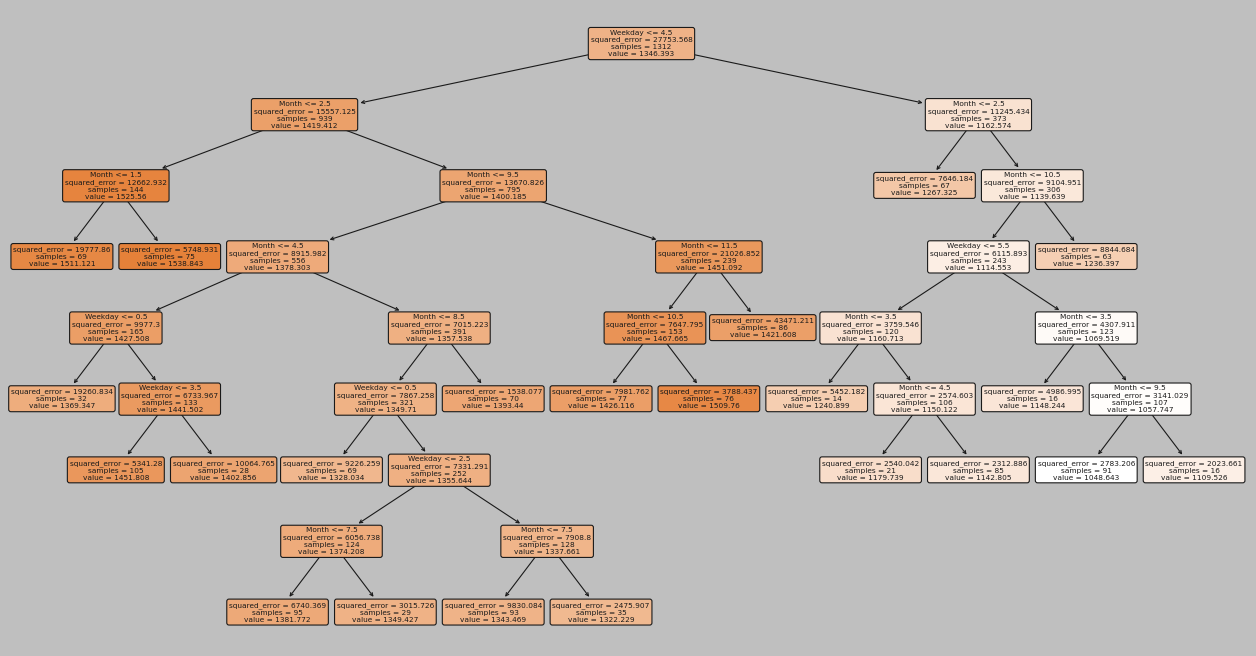

In [15]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)

|--- Weekday <= 4.50
|   |--- Month <= 2.50
|   |   |--- value: [1525.56]
|   |--- Month >  2.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1427.51]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- value: [1357.54]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1451.09]
|--- Weekday >  4.50
|   |--- value: [1162.57]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']
Mittelwert der wahren Label 1346.8
MAE 78.1641
MSE 11129.661
MAE% 5.803693818884207
MAPE% 6.103966649784897
RMSE% 7.833177068314725


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


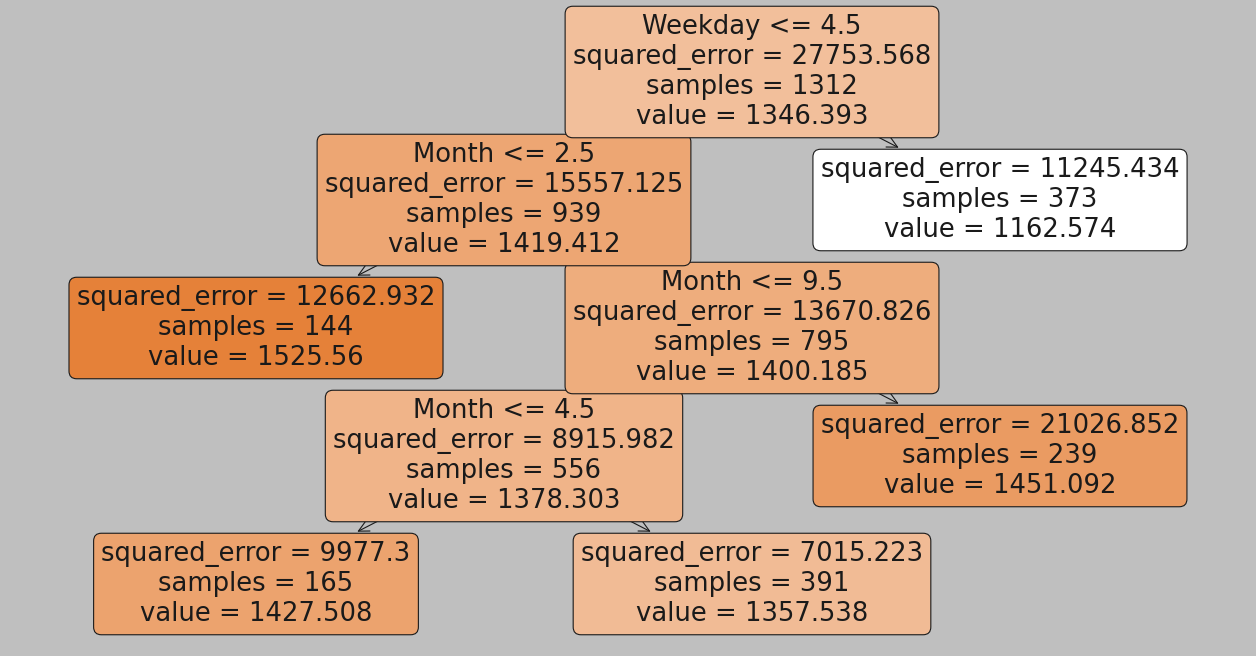

In [16]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar

# Diese Zeile wieder einkommentieren und anpassen
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split = 450, output=True)


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


Antwort: ...

In [17]:
# Performance des großen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

# Performance des kleinen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)


Mittelwert der wahren Label 1351.61
MAE 63.1659
MSE 7053.2628
MAE% 4.6733906829556195
MAPE% 4.787960780658608
RMSE% 6.213611740792905

Mittelwert der wahren Label 1351.61
MAE 72.4372
MSE 8696.528
MAE% 5.359333378155251
MAPE% 5.57976070011324
RMSE% 6.899570058913132


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


**Wie interpretieren Sie die Ergebnisse?** <br>
Die Abweichungen der relativen Metriken weichen ungefähr um einen Prozent voneinander ab. In Betracht der Komplexität des großen Entscheidungsbaums ist der kleinere Entscheidungsbaum durchaus vertretbar.
<br><br>
**Wäre der kleine Entscheidungsbaum vertretbar?** <br>
Da der kleine Entscheidungsbaum ein geringes Niveau hat, kann man daraus schließen, dass die zusätzliche Menge an Fehlern (~0.86%), die der kleine Entscheidungsbaum mehr macht, durch die Komplexität der unteren Ebenen des großen Entscheidungsbaums ersetzt werden.